This notebook is a little easier for beginners because it uses pytorch. You need to clone a repo to get it working:

```sh
# you need this repo, so clone it
git clone https://github.com/wassname/DeepRL.git
cd DeepRL
git reset --hard aeae2c5d585e5853dc638968b1f090eb60abd351
cd ..
mkdir data log evaluation_log
```

This contains some minor modifications from https://github.com/ShangtongZhang/DeepRL.git

The notebook tries DPPG with the [EIIE model](https://arxiv.org/pdf/1706.10059.pdf)

I also uncommented reward normalization in DDPG_agent.py#L64 because otherwise my small reward les to large Q's, inf losses, and NaN actions and weights.

In [10]:
# plotting
%matplotlib notebook
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# numeric
import numpy as np
from numpy import random
import pandas as pd

# utils
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import tempfile
import logging
import time
import datetime

# logging
logger = log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
logging.basicConfig()
log.info('%s logger started.', __name__)

INFO:__main__:__main__ logger started.
[2020-04-28 16:12:47,999] __main__ logger started.


In [11]:
import os
os.sys.path.append(os.path.abspath('.'))
os.sys.path.append(os.path.abspath('DeepRL'))
%reload_ext autoreload
%autoreload 2

In [6]:
# params
window_length = 50
steps = 128



In [7]:
# save dir
import datetime
ts = datetime.datetime.utcnow().strftime('%Y%m%d_%H-%M-%S')

save_path = './outputs/pytorch-DDPG/pytorch-DDPG-EIIE-action-crypto-%s.model' % ts
print(save_path)
try:
    os.makedirs(os.path.dirname(save_path))
except OSError:
    pass

./outputs/pytorch-DDPG/pytorch-DDPG-EIIE-action-crypto-20200428_20-05-33.model


In [8]:
# setup tensorboard logging
from tensorboard_logger import configure, log_value
tag = 'ddpg-' + ts
print('tensorboard --logdir '+"runs/" + tag)
try:
    configure("runs/" + tag)
except ValueError as e:
    print(e)
    pass

tensorboard --logdir runs/ddpg-20200428_20-05-33


# Env

In [9]:
from rl_portfolio_management.environments.portfolio import PortfolioEnv
from rl_portfolio_management.util import MDD, sharpe, softmax
from rl_portfolio_management.wrappers import SoftmaxActions, TransposeHistory, ConcatStates

df_train = pd.read_hdf('./data/poloniex_30m.hf',key='train')
df_test = pd.read_hdf('./data/poloniex_30m.hf',key='test')


In [8]:
import gym
class DeepRLWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.render_on_reset = False
        
        self.state_dim = self.observation_space.shape
        self.action_dim = self.action_space.shape[0]
        
        self.name = 'PortfolioEnv'
        self.success_threshold = 2
        
    def normalize_state(self, state):
        return state
    
    def step(self, action):
        state, reward, done, info =self.env.step(action)
        reward*=1e4 # often reward scaling is important sooo...
        return state, reward, done, info
    
    def reset(self):        
        # here's a roundabout way to get it to plot on reset
        if self.render_on_reset: 
            self.env.render('notebook')

        return self.env.reset()

In [9]:
def task_fn():
    env = PortfolioEnv(df=df_train, steps=steps, output_mode='EIIE')
    env = TransposeHistory(env)
    env = ConcatStates(env)
    env = SoftmaxActions(env)
    env = DeepRLWrapper(env)
    return env

def task_fn_test():
    env = PortfolioEnv(df=df_test, steps=steps, output_mode='EIIE')
    env = TransposeHistory(env)
    env = ConcatStates(env)
    env = SoftmaxActions(env)
    env = DeepRLWrapper(env)
    return env
    
# sanity check
task = task_fn()
task.reset().shape, task.step(task.action_space.sample())[0].shape

C:\Github\Senior_Sem\Ryan_ddpg-stock-trading-code\rl_portfolio_management\environments\portfolio.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = df.as_matrix().reshape(


((4, 51, 3), (4, 51, 3))

# Agent and models

In [10]:
# load
import pickle
import shutil

def save_ddpg(agent):
    agent_type = agent.__class__.__name__
    save_file = 'data/%s-%s-model-%s.bin' % (agent_type, config.tag, agent.task.name)
    agent.save(save_file)
    print(save_file)
    

def load_ddpg(agent):
    agent_type = agent.__class__.__name__
    save_file = 'data/%s-%s-model-%s.bin' % (agent_type, config.tag, agent.task.name)
    new_states = pickle.load(open(save_file, 'rb'))
    states = agent.worker_network.load_state_dict(new_states)


def load_stats_ddpg(agent):
    agent_type = agent.__class__.__name__
    online_stats_file = 'data/%s-%s-online-stats-%s.bin' % (
                    agent_type, config.tag, agent.task.name)
    try:
        steps, rewards = pickle.load(open(online_stats_file, 'rb'))
    except FileNotFoundError:
        steps =[]
        rewards=[]
    df_online = pd.DataFrame(np.array([steps, rewards]).T, columns=['steps','rewards'])
    if len(df_online):
        df_online['step'] = df_online['steps'].cumsum()
        df_online.index.name = 'episodes'
    
    stats_file = 'data/%s-%s-all-stats-%s.bin' % (agent_type, config.tag, agent.task.name)

    try:
        stats = pickle.load(open(stats_file, 'rb'))
    except FileNotFoundError:
        stats = {}
    df = pd.DataFrame(stats["test_rewards"], columns=['rewards'])
    if len(df):
#         df["steps"]=range(len(df))*50

        df.index.name = 'episodes'
    return df_online, df

In [11]:
import logging
from DeepRL.agent import ProximalPolicyOptimization
from DeepRL.network import DisjointActorCriticNet #, DeterministicActorNet, DeterministicCriticNet
from DeepRL.component import GaussianPolicy, HighDimActionReplay, OrnsteinUhlenbeckProcess
from DeepRL.utils import Config, Logger
import gym
import torch
gym.logger.setLevel(logging.INFO)

# Alg

In [12]:
# Modified from https://github.com/ShangtongZhang/DeepRL to log to tensorboard

from DeepRL.utils.normalizer import Normalizer

null_normaliser = lambda x:x

class DDPGAgent:
    def __init__(self, config):
        self.config = config
        self.task = config.task_fn()
        self.worker_network = config.network_fn()
        self.target_network = config.network_fn()
        self.target_network.load_state_dict(self.worker_network.state_dict())
        self.actor_opt = config.actor_optimizer_fn(self.worker_network.actor.parameters())
        self.critic_opt = config.critic_optimizer_fn(self.worker_network.critic.parameters())
        self.replay = config.replay_fn()
        self.random_process = config.random_process_fn()
        self.criterion = nn.MSELoss()
        self.total_steps = 0

        self.state_normalizer = Normalizer(self.task.state_dim) # null_normaliser # 
        self.reward_normalizer = Normalizer(1)

    def soft_update(self, target, src):
        for target_param, param in zip(target.parameters(), src.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.config.target_network_mix) +
                                    param.data * self.config.target_network_mix)

    def save(self, file_name):
        with open(file_name, 'wb') as f:
            torch.save(self.worker_network.state_dict(), f)

    def episode(self, deterministic=False, video_recorder=None):
        self.random_process.reset_states()
        state = self.task.reset()
        state = self.state_normalizer(state)

        config = self.config
        actor = self.worker_network.actor
        critic = self.worker_network.critic
        target_actor = self.target_network.actor
        target_critic = self.target_network.critic

        steps = 0
        total_reward = 0.0
        while True:
            actor.eval()
            action = actor.predict(np.stack([state])).flatten()
            if not deterministic:
                action += self.random_process.sample()
            next_state, reward, done, info = self.task.step(action)
            if video_recorder is not None:
                video_recorder.capture_frame()
            done = (done or (config.max_episode_length and steps >= config.max_episode_length))
            next_state = self.state_normalizer(next_state) * config.reward_scaling
            total_reward += reward
            
            # tensorboard logging
            prefix = 'test_' if deterministic else ''
            log_value(prefix + 'reward', reward, self.total_steps)
#             log_value(prefix + 'action', action, steps)
            log_value('memory_size', self.replay.size(), self.total_steps)     
            for key in info:
                log_value(key, info[key], self.total_steps)     
            
            reward = self.reward_normalizer(reward)

            if not deterministic:
                self.replay.feed([state, action, reward, next_state, int(done)])
                self.total_steps += 1

            steps += 1
            state = next_state

            if done:
                break

            if not deterministic and self.replay.size() >= config.min_memory_size:
                self.worker_network.train()
                experiences = self.replay.sample()
                states, actions, rewards, next_states, terminals = experiences
                q_next = target_critic.predict(next_states, target_actor.predict(next_states))
                terminals = critic.to_torch_variable(terminals).unsqueeze(1)
                rewards = critic.to_torch_variable(rewards).unsqueeze(1)
                q_next = config.discount * q_next * (1 - terminals)
                q_next.add_(rewards)
                q_next = q_next.detach()
                q = critic.predict(states, actions)
                critic_loss = self.criterion(q, q_next)

                critic.zero_grad()
                self.critic_opt.zero_grad()
                critic_loss.backward()
                if config.gradient_clip:
                    grad_critic = nn.utils.clip_grad_norm(self.worker_network.parameters(), config.gradient_clip)
                self.critic_opt.step()

                actions = actor.predict(states, False)
                var_actions = Variable(actions.data, requires_grad=True)
                q = critic.predict(states, var_actions)
                q.backward(torch.ones(q.size()))

                actor.zero_grad()
                self.actor_opt.zero_grad()
                actions.backward(-var_actions.grad.data)
                if config.gradient_clip:
                    grad_actor = nn.utils.clip_grad_norm(self.worker_network.parameters(), config.gradient_clip)
                self.actor_opt.step()
                
                # tensorboard logging
                log_value('critic_loss', critic_loss.cpu().data.numpy().squeeze(), self.total_steps)
                log_value('loss_action', -q.sum(), self.total_steps)
                if config.gradient_clip:
                    log_value('grad_critic', grad_critic, self.total_steps)
                    log_value('grad_actor', grad_actor, self.total_steps)

                self.soft_update(self.target_network, self.worker_network)

        return total_reward, steps

# Model

In [13]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [14]:
task.state_dim, task.action_dim

((4, 51, 3), 4)

In [15]:

from DeepRL.network.base_network import BasicNet

class DeterministicActorNet(nn.Module, BasicNet):
    def __init__(self,
                 state_dim,
                 action_dim,
                 action_gate,
                 action_scale,
                 gpu=False,
                 batch_norm=False,
                 non_linear=F.relu):
        super(DeterministicActorNet, self).__init__()

        stride_time = state_dim[1] - 1 - 2 #
        features = task.state_dim[0]
        h0 = 2
        h1 = 30
        self.conv1 = nn.Conv2d(features, h0, (3, 1))
        self.conv2 = nn.Conv2d(h0, h1, (stride_time, 1), stride=(stride_time, 1))
        self.conv3 = nn.Conv2d((h1+1), 1, (1, 1))

        self.action_scale = action_scale
        self.action_gate = action_gate
        self.non_linear = non_linear

        if batch_norm:
            self.bn1 = nn.BatchNorm1d(h0)
            self.bn2 = nn.BatchNorm1d(h1)

        self.batch_norm = batch_norm
        BasicNet.__init__(self, None, gpu, False)


    def forward(self, x):
        x = self.to_torch_variable(x)
        
        w0 = x[:,:1,:1,:] # weights from last step 
        x = x[:,:,1:,:]
        
        phi0 = self.non_linear(self.conv1(x))
        if self.batch_norm:
            phi0 = self.bn1(phi0)
        phi1 = self.non_linear(self.conv2(phi0))
        h = torch.cat([phi1,w0], 1)
        if self.batch_norm:
            h = self.bn2(h)
        
        action = self.conv3(h)
        
        # add cash_bias before we softmax
        cash_bias_int = 0
        cash_bias = self.to_torch_variable(torch.ones(action.size())[:,:,:,:1] * cash_bias_int)
        action = torch.cat([cash_bias, action], -1)
        
        batch_size = action.size()[0]
        action = action.view((batch_size,-1))
        if self.action_gate:
            action = self.action_scale * self.action_gate(action)
        return action

    def predict(self, x, to_numpy=True):
        y = self.forward(x)
        if to_numpy:
            y = y.cpu().data.numpy()
        return y

class DeterministicCriticNet(nn.Module, BasicNet):
    def __init__(self,
                 state_dim,
                 action_dim,
                 gpu=False,
                 batch_norm=False,
                 non_linear=F.relu):
        super(DeterministicCriticNet, self).__init__()
        stride_time = state_dim[1] - 1 - 2 #
        self.features = features = task.state_dim[0]
        h0=2
        h1=20
        self.action = actions = action_dim -1
        self.conv1 = nn.Conv2d(features, h0, (3, 1))
        self.conv2 = nn.Conv2d(h0, h1, (stride_time, 1), stride=(stride_time, 1))
        self.layer3 = nn.Linear((h1+2)*actions, 1)
        self.non_linear = non_linear

        if batch_norm:
            self.bn1 = nn.BatchNorm1d(h0)
            self.bn2 = nn.BatchNorm1d(h1)
        self.batch_norm = batch_norm

        BasicNet.__init__(self, None, gpu, False)


    def forward(self, x, action):
        x = self.to_torch_variable(x)
        action = self.to_torch_variable(action)[:,None,None,:-1] # remove cash bias
        
        w0 = x[:,:1,:1,:] # weights from last step 
        x = x[:,:,1:,:]
        
        phi0 = self.non_linear(self.conv1(x))
        if self.batch_norm:
            phi0 = self.bn1(phi0)
        phi1 = self.non_linear(self.conv2(phi0))
        h = torch.cat([phi1,w0,action], 1)
        if self.batch_norm:
            h = self.bn2(h)
        
        batch_size = x.size()[0]
        action = self.layer3(h.view((batch_size,-1)))
        return action

    def predict(self, x, action):
        return self.forward(x, action)

# Config

In [17]:
config = Config()
config.task_fn = task_fn
task = config.task_fn()
config.actor_network_fn = lambda: DeterministicActorNet(
    task.state_dim, task.action_dim, action_gate=None, action_scale=1.0, non_linear=F.relu, batch_norm=False, gpu=False)
config.critic_network_fn = lambda: DeterministicCriticNet(
    task.state_dim, task.action_dim, non_linear=F.relu, batch_norm=False, gpu=False)
config.network_fn = lambda: DisjointActorCriticNet(config.actor_network_fn, config.critic_network_fn)
config.actor_optimizer_fn = lambda params: torch.optim.Adam(params, lr=4e-5)
config.critic_optimizer_fn =\
    lambda params: torch.optim.Adam(params, lr=5e-4, weight_decay=0.001)
config.replay_fn = lambda: HighDimActionReplay(memory_size=600, batch_size=64)
config.random_process_fn = \
    lambda: OrnsteinUhlenbeckProcess(size=task.action_dim, theta=0.15, sigma=0.2, sigma_min=0.00002, n_steps_annealing=10000)
config.discount = 0.0

config.min_memory_size = 50
config.target_network_mix = 0.001
config.max_steps = 300000
config.max_episode_length = 3000 
config.target_network_mix = 0.01
config.noise_decay_interval = 100000
config.gradient_clip = 20
config.min_epsilon = 0.1

# Many papers have found rewards scaling to be an important parameter. But while they focus on the scaling factor
# I think they should focus on the end variance with a range of 200-400. e.g. https://arxiv.org/pdf/1709.06560.pdf
# Hard to tell for sure without experiments to prove it
config.reward_scaling = 1000

# config.test_interval = 10 # ORIGINALLY
config.test_interval = 2 # TODO: Remove (quick test)
config.test_repetitions = 1
# config.save_interval = 40 # ORIGINALLY
config.save_interval = 4 # TODO: Remove (quick test)
config.logger = Logger('./log', gym.logger)
config.tag = tag
agent = DDPGAgent(config)
agent

# Train

In [18]:
from DeepRL.utils import run_episodes
agent.task._plot = agent.task._plot2 = None
try:    
    run_episodes(agent)
except KeyboardInterrupt as e:
    save_ddpg(agent)
    raise(e)

<ipython-input-12-e78b22bcedac>:95: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  grad_critic = nn.utils.clip_grad_norm(self.worker_network.parameters(), config.gradient_clip)
<ipython-input-12-e78b22bcedac>:107: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  grad_actor = nn.utils.clip_grad_norm(self.worker_network.parameters(), config.gradient_clip)
INFO:gym:episode 1, reward 0.764723, avg reward 0.764723, total steps 128, episode step 128
[2020-04-28 14:35:19,356] episode 1, reward 0.764723, avg reward 0.764723, total steps 128, episode step 128
INFO:gym:episode 2, reward -7.085758, avg reward -3.160518, total steps 256, episode step 128
[2020-04-28 14:35:22,251] episode 2, reward -7.085758, avg reward -3.160518, total steps 256, episode step 128
INFO:gym:Testing...
[2020-04-28 14:35:22,253] Testing...
INFO:gym:Avg reward -0.861272(0.000000)
[2020-04-28 14:35:22,86

INFO:gym:Testing...
[2020-04-28 14:36:47,393] Testing...
INFO:gym:Avg reward 4.261185(0.000000)
[2020-04-28 14:36:48,025] Avg reward 4.261185(0.000000)
INFO:gym:episode 29, reward -0.335821, avg reward -1.251018, total steps 3712, episode step 128
[2020-04-28 14:36:50,937] episode 29, reward -0.335821, avg reward -1.251018, total steps 3712, episode step 128
INFO:gym:episode 30, reward -1.274537, avg reward -1.251802, total steps 3840, episode step 128
[2020-04-28 14:36:53,832] episode 30, reward -1.274537, avg reward -1.251802, total steps 3840, episode step 128
INFO:gym:Testing...
[2020-04-28 14:36:53,834] Testing...
INFO:gym:Avg reward -0.166664(0.000000)
[2020-04-28 14:36:54,453] Avg reward -0.166664(0.000000)
INFO:gym:episode 31, reward -7.083627, avg reward -1.439926, total steps 3968, episode step 128
[2020-04-28 14:36:57,369] episode 31, reward -7.083627, avg reward -1.439926, total steps 3968, episode step 128
INFO:gym:episode 32, reward 3.617819, avg reward -1.281871, total s

[2020-04-28 14:38:22,797] episode 57, reward -3.343153, avg reward -1.790150, total steps 7296, episode step 128
INFO:gym:episode 58, reward 0.590190, avg reward -1.749109, total steps 7424, episode step 128
[2020-04-28 14:38:25,822] episode 58, reward 0.590190, avg reward -1.749109, total steps 7424, episode step 128
INFO:gym:Testing...
[2020-04-28 14:38:25,823] Testing...
INFO:gym:Avg reward 1.284517(0.000000)
[2020-04-28 14:38:26,426] Avg reward 1.284517(0.000000)
INFO:gym:episode 59, reward 3.692815, avg reward -1.656873, total steps 7552, episode step 128
[2020-04-28 14:38:29,363] episode 59, reward 3.692815, avg reward -1.656873, total steps 7552, episode step 128
INFO:gym:episode 60, reward -0.696631, avg reward -1.640869, total steps 7680, episode step 128
[2020-04-28 14:38:32,298] episode 60, reward -0.696631, avg reward -1.640869, total steps 7680, episode step 128
INFO:gym:Testing...
[2020-04-28 14:38:32,301] Testing...
INFO:gym:Avg reward -1.011411(0.000000)
[2020-04-28 14:

INFO:gym:Testing...
[2020-04-28 14:39:58,032] Testing...
INFO:gym:Avg reward 2.343010(0.000000)
[2020-04-28 14:39:58,633] Avg reward 2.343010(0.000000)
INFO:gym:episode 87, reward 5.579612, avg reward -0.757640, total steps 11136, episode step 128
[2020-04-28 14:40:01,627] episode 87, reward 5.579612, avg reward -0.757640, total steps 11136, episode step 128
INFO:gym:episode 88, reward -4.058018, avg reward -0.795144, total steps 11264, episode step 128
[2020-04-28 14:40:04,611] episode 88, reward -4.058018, avg reward -0.795144, total steps 11264, episode step 128
INFO:gym:Testing...
[2020-04-28 14:40:04,614] Testing...
INFO:gym:Avg reward -10.248102(0.000000)
[2020-04-28 14:40:05,246] Avg reward -10.248102(0.000000)
INFO:gym:episode 89, reward 3.579178, avg reward -0.745995, total steps 11392, episode step 128
[2020-04-28 14:40:08,315] episode 89, reward 3.579178, avg reward -0.745995, total steps 11392, episode step 128
INFO:gym:episode 90, reward 1.307445, avg reward -0.723179, tot

INFO:gym:episode 115, reward -8.245093, avg reward -0.812781, total steps 14720, episode step 128
[2020-04-28 14:41:35,174] episode 115, reward -8.245093, avg reward -0.812781, total steps 14720, episode step 128
INFO:gym:episode 116, reward 3.389489, avg reward -0.807737, total steps 14848, episode step 128
[2020-04-28 14:41:38,606] episode 116, reward 3.389489, avg reward -0.807737, total steps 14848, episode step 128
INFO:gym:Testing...
[2020-04-28 14:41:38,609] Testing...
INFO:gym:Avg reward -10.922421(0.000000)
[2020-04-28 14:41:39,338] Avg reward -10.922421(0.000000)
INFO:gym:episode 117, reward 1.078257, avg reward -0.893796, total steps 14976, episode step 128
[2020-04-28 14:41:43,020] episode 117, reward 1.078257, avg reward -0.893796, total steps 14976, episode step 128
INFO:gym:episode 118, reward 6.724563, avg reward -0.883514, total steps 15104, episode step 128
[2020-04-28 14:41:46,512] episode 118, reward 6.724563, avg reward -0.883514, total steps 15104, episode step 12

data/DDPGAgent-ddpg-20200428_18-34-26-model-PortfolioEnv.bin


KeyboardInterrupt: 

# History

<IPython.core.display.Javascript object>


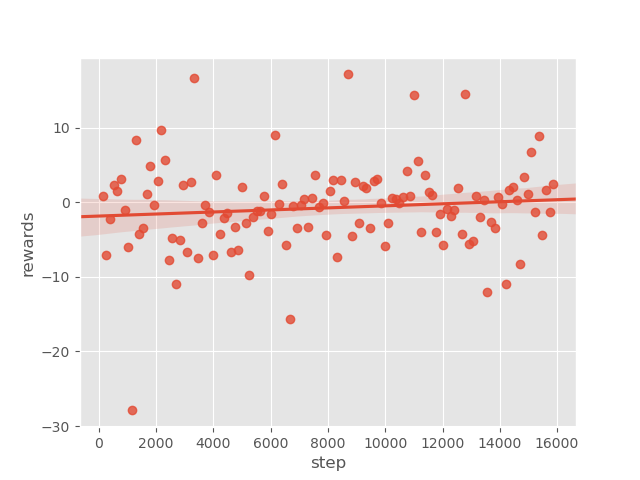

In [19]:
# plot rewards
plt.figure()
df_online, df = load_stats_ddpg(agent)
sns.regplot(x="step", y="rewards", data=df_online, order=1)

In [20]:
# monthly growth
portfolio_return = (1+df_online.rewards[-100:].mean())

returns = task.unwrapped.src.data[0,:,:1]
market_return = (1+returns).mean()
market_return, portfolio_return

(1.0149224, 0.5055381605746134)

# Test

In [21]:
def test_algo(env, algo, seed=0):
    """
    Runs and algo from https://github.com/Marigold/universal-portfolios on env
    
    https://github.com/Marigold/universal-portfolios/commit/e8970a82427522ef11b1c3cbf681e18b5fe8169c
    """
    env.seed(0)
    np.random.seed(0)

    state = env.reset()
    for i in range(env.unwrapped.sim.steps):
        
        history= pd.DataFrame(state[0,:,:], columns=env.unwrapped.src.asset_names)
        # MPT wants a cash column, and it should be first
        history['CASH']=1
        history=history[['CASH'] + env.unwrapped.src.asset_names]
#         cols = list(history.columns)
#         cols[0]='CASH'
#         history.columns = cols
        
        x=history.iloc[-1]
        
        last_b = env.unwrapped.sim.w0#[1:]

        algo.init_step(history)
        # some don't want history
        try:
            action = algo.step(x, last_b, history)
        except TypeError:
            action = algo.step(x, last_b)
        
        # might by dataframe
        action = getattr(action, 'value', action)
        
        # For upt
        if isinstance(action, np.matrixlib.defmatrix.matrix):
            action = np.array(action.tolist()).T[0]
            
        

        state, reward, done, info = env.step(action)

        if done:
            break   
    df = pd.DataFrame(env.unwrapped.infos)
    df.index = pd.to_datetime(df['date']*1e9)
    return df['portfolio_value'], df

C:\Github\Senior_Sem\Ryan_ddpg-stock-trading-code\rl_portfolio_management\environments\portfolio.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = df.as_matrix().reshape(


<IPython.core.display.Javascript object>


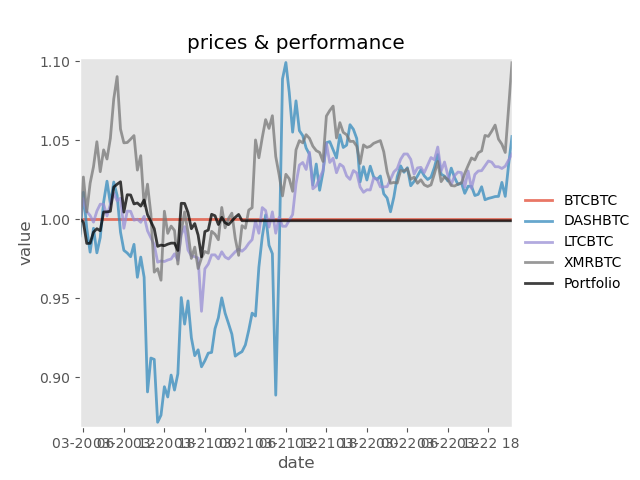

C:\Users\lizar\AppData\Local\Continuum\anaconda3\envs\test\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>


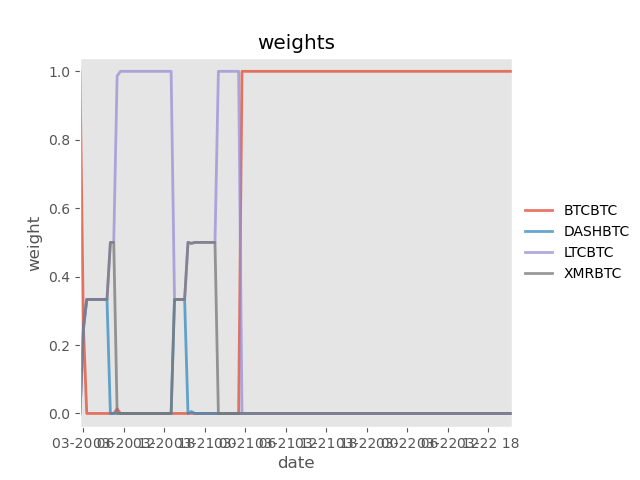

<IPython.core.display.Javascript object>


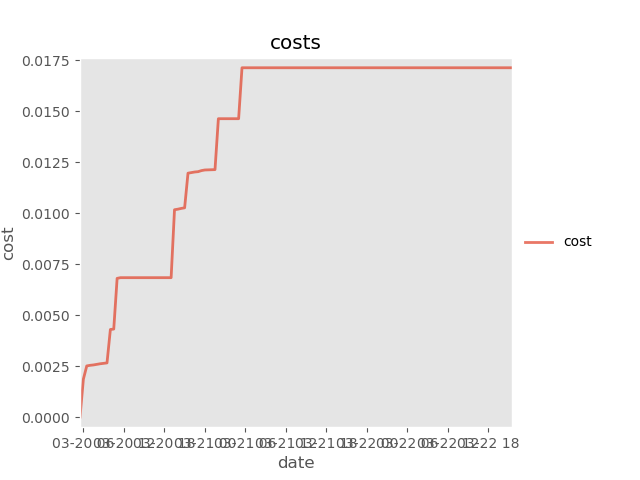

In [22]:
# use test env
df_test = pd.read_hdf('./data/poloniex_30m.hf',key='test')
test_steps=5000
env_test = task_fn_test()
agent.task = env_test
agent.config.max_episode_length = test_steps
agent.task.reset()
np.random.seed(0)

# run in deterministic mode, no training, no exploration
agent.episode(True)
agent.task.render('notebook')
agent.task.render('notebook', True)

df = pd.DataFrame(agent.task.unwrapped.infos)
df.index = pd.to_datetime(df['date']*1e9)

BestSoFar
ONS
RMR


<IPython.core.display.Javascript object>


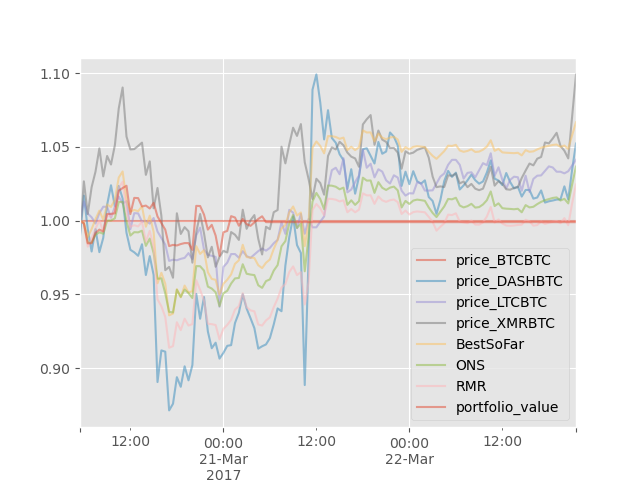

In [27]:
from UniversalPortfolios.universal import algos
env = task.unwrapped
price_cols = [col for col in df.columns if col.startswith('price')]
for col in price_cols:
    df[col]=df[col].cumprod()

df = df[price_cols + ['portfolio_value']]
    
algo_dict=dict(
    # Pick the same is in https://arxiv.org/pdf/1706.10059.pdf
    # Benchmarks
#     UCRP=algos.UP(),
    
    # Follow the winner
    BestSoFar=algos.BestSoFar(cov_window=env_test.unwrapped.src.window_length-1),
#     UniversalPortfolio=algos.UP(eval_points=1000),
    ONS=algos.ONS(),
    
    # Follow the loser
#     OnlineMovingAverageReversion=algos.OLMAR(window=env.src.window_length-1, eps=10), 
    RMR=algos.RMR(window=env_test.unwrapped.src.window_length-1, eps=10),
#     PassiveAggressiveMeanReversion=algos.PAMR(),
    
    # Pattern matching
    #     CorrelationDrivenNonparametricLearning=algos.CORN(window=30),
)
for name, algo in algo_dict.items():
    print(name)
    perf, _ = test_algo(env_test, algo)
    perf.index=df.index
    df[name]=perf

# put portfolio value at end so we plot it on top and can therefore see it
cols = list(df.columns.drop('portfolio_value'))+['portfolio_value']
df=df[cols]


df.plot(alpha=0.5)